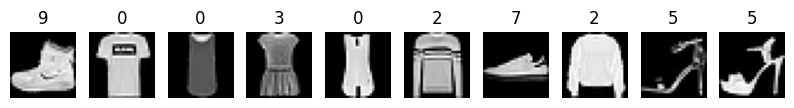

X: 70000  Y: 70000


In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

mnist = fetch_openml('fashion-mnist', version=1)
X, y = mnist.data, mnist.target

# Reshape one sample to 28x28 and plot first 10 images
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(y[i])

plt.show()
X = X/255
X = [X.iloc[i].values.reshape(28, 28).tolist() for i in range(X.shape[0])]
y = y.tolist()
print(f'X: {len(X)}  Y: {len(y)}')

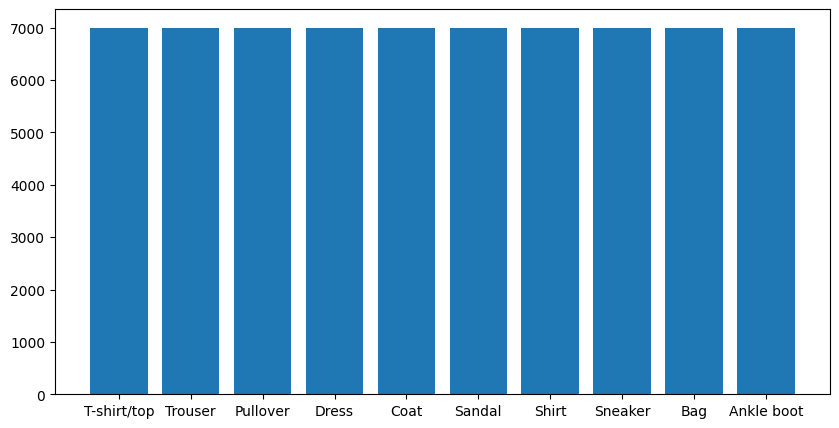

In [13]:
fashion_mnist_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

ct = [0 for i in range(10)]
for i in y:
    ct[int(i)] += 1

plt.figure(figsize=(10, 5))
plt.bar(fashion_mnist_labels, ct)
plt.show()